<a href="https://colab.research.google.com/github/EddyGiusepe/Pytorch_Deep_Learning/blob/main/Pytorch_Redes_Conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução a Redes Convolucionais com Pytorch

Data scientist.: Dr.Eddy Giusepe Chirinos Isidro

Aqui vamos focar no estudo de uma ``Rede Convolucional``, lecionado pelo [Rodrigo Guerra](https://www.youtube.com/watch?v=CvbKQUeBsfw).


Link de estudo:

* [Redes Convolucionais - Parte 1](https://www.youtube.com/watch?v=CvbKQUeBsfw).



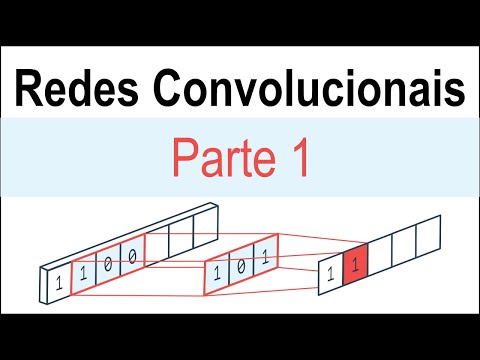

In [34]:
# Aqui carregamos o vídeo dele

from IPython.display import YouTubeVideo
YouTubeVideo('CvbKQUeBsfw')

## Introdução às Redes Convolucionais

Nesse notebook vamos experimentar criar uma ``Rede Neural Convolucional`` para classificar dados de uma ``série temporal`` de uma única variável. A base de dados que vamos usar se chama _GunPoint_. Dois voluntários participaram na geração desses dados. Eles estavam em pé e foram filmados de lado enquando faziam uma de duas possíveis ações: 

* sacar uma arma e apontar para frente, ou 

* simplesmente levantar o braço e apontar com o dedo para frente. 


Durante o gesto foi rastreada a posição $x,y$ da mão do ator, mas na base de dados foi registrada apenas a variável $x$. O problema consiste em, a partir apenas desse dado da posição da mão no eixo horizontal ao longo do tempo (``variável x como série temporal``), tentar determinar se o ator estava sacando uma arma e apontando ela, ou apenas apontando com o dedo.

<img src="https://drive.google.com/uc?id=1fZ5j2rZDVyqBkqs66S4R-LqTIfdhbqD2" width="500"/>

## Obtenção dos Dados

O código das próximas células baixa os dados e os organiza para separar e embaralhar pares de treinamento e validação como tensores do PyTorch.

In [35]:
# Importa as bibliotecas que usaremos
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


# Ajusta os parâmetro de precisão para
# as variáveis que serão impressas na tela

torch.set_printoptions(precision=2, sci_mode=False)
np.set_printoptions(precision=2)


In [36]:
# Baixa o dataset GunPoint

!gdown --id '1ngmxYWCr5v7NG7Nz8dkMq8mtswokIb2B'

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1ngmxYWCr5v7NG7Nz8dkMq8mtswokIb2B
To: /content/GunPoint.zip
100% 435k/435k [00:00<00:00, 153MB/s]


In [37]:
# Expande o arquivo "zipado"
!unzip -o GunPoint.zip

Archive:  GunPoint.zip
  inflating: GunPoint.txt            
  inflating: GunPoint_TEST.arff      
  inflating: GunPoint_TEST.txt       
  inflating: GunPoint_TRAIN.arff     
  inflating: GunPoint_TRAIN.txt      
  inflating: GunPoint_TEST.ts        
  inflating: GunPoint_TRAIN.ts       


In [38]:
def load_file(filename):
  ''' Essa função lê o arquivo com a série de
      dados do dataset GunPoint, retornando
      o par de entrada e saída desejada
  '''

  # Essas listas vão conter as entradas (séries temporais)
  # e respectivas saídas desejadas (classes no formato
  # one-hot)

  X = list()
  Y = list()

  # Abre o arquivo e carrega as linhas

  f = open(filename, 'r')
  lines = f.readlines()

  # Laço que converte os dados lidos,
  # linha por linha

  for line in lines:

    # Aqui lemos a sequência de dados ponto flutuante,
    # separada por espaços duplos, descartando os espaços
    # iniciais e o caracter de nova linha ao final de
    # cada linha

    data = [float(x) for x in line[3:-1].split('  ')]

    # O primeiro número representa a classe que
    # aqui é convertida o índice zero ou um

    Y.append(int(data[0]-1))

    # Os demais números são a sequência de posições
    # da mão do ator ou da atriz no eixo x

    X.append(data[1:])
  
  # Embaralhamento das amostras

  idxs = list(range(len(X)))
  np.random.shuffle(idxs)
  X_ = list()
  Y_ = list()
  for i in idxs:
    X_.append(X[i])
    Y_.append(Y[i])

  # Retornamos o par X, Y
  
  return torch.tensor(X_), torch.tensor(Y_)

In [39]:
# Leitura dos pares de treinamento e validação

Xt, Yt = load_file('GunPoint_TRAIN.txt')
Xv, Yv = load_file('GunPoint_TEST.txt')

In [40]:
Xt.shape

torch.Size([50, 150])

In [41]:
Yt.shape

torch.Size([50])

In [42]:
Xv.shape

torch.Size([150, 150])

In [43]:
Yv.shape

torch.Size([150])

## Verificação do Dataset

Abaixo tentamos dar uma breve examinada no dataset que acabamos de baixar

In [44]:
# Aqui verificamos o tamanho do dataset
# e a quantidade de amostras em cada série

print(Xt.size())
print(Xv.size())

torch.Size([50, 150])
torch.Size([150, 150])


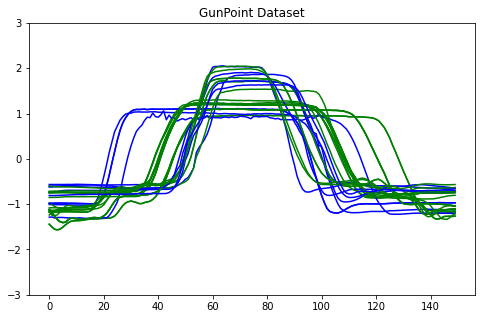

In [45]:
# Aqui plotamos alguns exemplos de dados
# desse dadaset para examinar como são
# as curvas de cada classe.

fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.set_ylim(-3, 3)
ax.set_title('GunPoint Dataset')

for _ in range(30):
  idx = np.random.randint(0,len(Xt))
  c = Yt[idx]
  ax.plot(Xt[idx], 'g' if c == 0 else 'b')
plt.show()


## Definição da Rede Neural

Note que por enquanto não estamos usando o objeto específico `Conv1d` do PyTorch. Estamos apenas usando as combinações lineares (multiplica pelos pesos e soma o bias usando `Linear`, depois aplica a função de ativação `sigmoid`). Criamos a convolução manualmente usando um laço `for`.

In [46]:
class ConvNet(nn.Module):
  ''' Essa é nossa classe da rede
      convolucional que estamos criando
      manualmente.
  '''
  def __init__(self):

    # Construtor da classe mãe
    super(ConvNet, self).__init__()

    # A janela da convolução terá tamanho 10
    # e uma saída apenas (se diz que tem 1 canal
    # de saída)

    self.wb1 = nn.Linear(20,1)

    # Depois da convolução adicionamos apenas
    # mais uma camada que coleta os 29 valores
    # gerados durante a convolução anterior
    # e calcula duas saídas

    self.wb2 = nn.Linear(14,2)

  def forward(self, x):

    # Aqui criamos o tensor que armazenará
    # os resultados da convolução
    s1 = torch.zeros(len(x),14)
    
    # Se estivermos usando a GPU vamos
    # então mover essa variável para lá
    if torch.cuda.is_available():
      s1 = s1.cuda()

    # Esse laço aplica a convolução
    for i in range(14):
      s1[:,i:i+1] = self.wb1(x[:,i*10:i*10+20])
    
    # Ativação
    z1 = torch.sigmoid(s1)

    # Última camada e valor de retorno
    s2 = self.wb2(z1)
    return s2


    # Pode usar também:
    
    # super(ConvNet, self).__init__()
    # self.c1 = nn.Conv1d(1, 1, 20, stride=10)
    # self.c2 = nn.Linear(14, 2)

    # def forward(self, x):
    #   x = x.unsqueeze(1)
    #   s1 = self.c1(x)
    #   s1 = s1.view(-1, 14)
    #   z1 = torch.sigmoid(s1)
    #   s2 = self.c2(z1)
    #   return s2    
    

In [47]:
# Aqui criamos o objeto
cnn = ConvNet()

print(cnn)

ConvNet(
  (wb1): Linear(in_features=20, out_features=1, bias=True)
  (wb2): Linear(in_features=14, out_features=2, bias=True)
)


In [48]:
print(list(cnn.parameters()))

[Parameter containing:
tensor([[ 0.11,  0.08,  0.19, -0.15, -0.17,  0.03, -0.16, -0.07,  0.15,  0.21,
          0.05,  0.22, -0.13,  0.22,  0.21,  0.13, -0.13, -0.14, -0.03, -0.14]],
       requires_grad=True), Parameter containing:
tensor([-0.13], requires_grad=True), Parameter containing:
tensor([[    -0.10,      0.27,     -0.04,     -0.25,      0.13,      0.16,
              0.23,      0.21,      0.05,      0.06,      0.15,      0.05,
              0.16,      0.02],
        [     0.06,      0.17,     -0.01,      0.23,      0.01,      0.23,
              0.07,     -0.04,      0.13,      0.00,     -0.15,     -0.22,
             -0.01,      0.02]], requires_grad=True), Parameter containing:
tensor([-0.17, -0.23], requires_grad=True)]


## Treinamento

A seguir realizamos o treinamento da rede neural. Note que no treinamento nada muda em relação ao que fizemos na rede estilo ``Perceptron``.

In [49]:
# Aqui criamos o otimizador e a função
# de perda

opt = optim.SGD(cnn.parameters(), lr=1.0)
loss = nn.CrossEntropyLoss()

In [50]:
# Movemos tudo para a GPU
# (essa parte é opcional)

gpu = torch.device("cuda:0")
cnn = cnn.to(gpu)
Xt = Xt.to(gpu)
Yt = Yt.to(gpu)
Xv = Xv.to(gpu)
Yv = Yv.to(gpu)

In [51]:
# Treinamento por 10 mil épocas
# (pode repetir essa célula várias
#  vezes para tentar aumentar a
#  acurácia)

for j in range(10001):
  x = Xt
  y_hat = Yt
  opt.zero_grad()
  y = cnn(x)
  e = loss(y, y_hat)
  e.backward()
  opt.step()
  if not (j % 1000):
    print(float(e))

0.7082642316818237
0.02071661874651909
0.007928461767733097
0.00470881350338459
0.0032785385847091675
0.0024812952615320683
0.001978242304176092
0.0016346287447959185
0.001386541873216629
0.0011998872505500913
0.0010548679856583476


## Verificação dos Resultados

Por fim, examinamos a acurácia nos dados de validação.

In [52]:
# Aqui verificamos a acurácia nos dados
# de validação

x = Xv
y_hat = Yv
y = cnn(x).argmax(dim=1)
print('Acurácia',100*float((y == y_hat).sum()) / len(x))

Acurácia 96.0
